Name: Antony Krymski

Username: agk-123

# CPC for Financial Time-Series

Importing all utils.

In [15]:
import utils
from utils.imports import *
from utils.utilities import *
from utils.data_generator_cpc import *
import importlib

Should be able to run the 3 cells below if you made changes to utils.

In [16]:
importlib.reload(utils.imports)

<module 'utils.imports' from '/Users/antonykrymski/dev/imperial/irp-agk123/src/utils/imports.py'>

In [17]:
importlib.reload(utils.utilities)

<module 'utils.utilities' from '/Users/antonykrymski/dev/imperial/irp-agk123/src/utils/utilities.py'>

In [18]:
importlib.reload(utils.data_generator_cpc)

<module 'utils.data_generator_cpc' from '/Users/antonykrymski/dev/imperial/irp-agk123/src/utils/data_generator_cpc.py'>

Parameters used for all training.

In [19]:
WINDOWS = 10
TIMESTEPS = 25
FEATURES = 1
CODE_SIZE = 32
BATCH_SIZE = 512

# Data

## Pre-processing

Downloading USDJPY daily closing prices

In [20]:
timeseries = download('JPY=X')['Close']

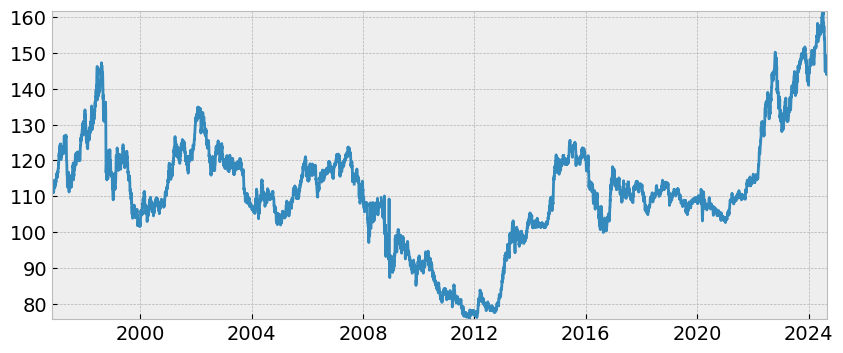

In [21]:
plot(timeseries)

In [22]:
# Transform to log returns
timeseries = np.log(timeseries).diff().dropna()
timeseries

Date
1996-11-04    0.003342
1996-11-05    0.003244
1996-11-06   -0.002629
1996-11-11   -0.005564
1996-11-12    0.001888
                ...   
2024-08-26   -0.015176
2024-08-27    0.003577
2024-08-28   -0.003751
2024-08-29    0.003176
2024-08-30    0.004476
Name: Close, Length: 7190, dtype: float64

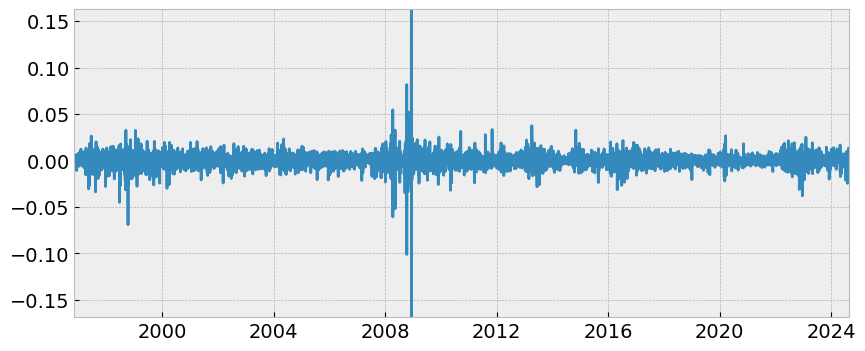

In [23]:
plot(timeseries)

Splitting and pre-processing data.

Outliers 0.021903799967386648
(5552, 250) (1388, 250)
(5552,) (1388,)


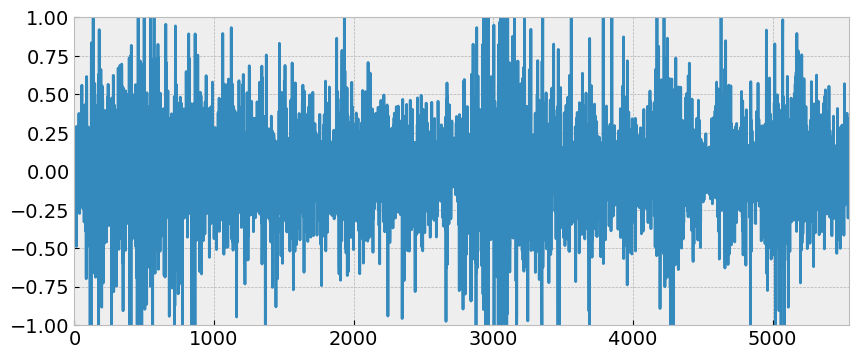

In [24]:
x_train, x_test, y_train, y_test = load_data(timeseries, WINDOWS * TIMESTEPS, test_ratio=0.2)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

assert(np.isfinite(x_train).all() == True)
assert(np.isfinite(y_train).all() == True)

plot(x_train[:, 0])

# Baselines

In [11]:
evals = evals_initialise()

In [12]:
# Base cases
evals['Persistance'] = eval('Persistence', y_test.shift(1).fillna(0), y_test)
evals['Zero'] = eval('Zero', np.zeros(len(y_test)), y_test)
evals['Mean'] = eval('Mean', np.full(len(y_test), np.mean(x_train[:, -1])), y_test)
evals

,Persistance,Zero,Mean
RMSE,0.007791,0.005563,0.005567
MAE,0.005549,0.003886,0.003896


# LR

In [13]:
# Linear Regression
model = LinearRegression()
model.fit(x_train, y_train)
evals['LR'] = eval('LR', model.predict(x_test), y_test)
evals

# LSTM

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/40


2024-08-30 01:29:47.915440: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11/11 [==============================] - 4s 213ms/step - loss: 3.1468e-04 - mae: 0.0109 - val_loss: 3.2120e-05 - val_mae: 0.0040
Epoch 2/40
11/11 [==============================] - 2s 157ms/step - loss: 7.4357e-05 - mae: 0.0058 - val_loss: 3.5175e-05 - val_mae: 0.0044
Epoch 3/40
11/11 [==============================] - 2s 156ms/step - loss: 9.0620e-05 - mae: 0.0068 - val_loss: 3.1435e-05 - val_mae: 0.0039
Epoch 4/40
11/11 [==============================] - 2s 158ms/step - loss: 8.7474e-05 - mae: 0.0067 - val_loss: 3.4911e-05 - val_mae: 0.0043
Epoch 5/40
11/11 [==============================] - 2s 156ms/step - loss: 7.5448e-05 - mae: 0.0060 - val_loss: 4.7713e-05 - val_mae: 0.0053
Epoch 6/40
11/11 [==============================] - 2s 159ms/step - loss: 7.6015e-05 - mae: 0.0060 - val_loss: 4.5312e-05 - val_mae: 0.0051
Epoch 7/40
11/11 [==============================] - 2s 161ms/step - loss: 6.6546e-05 - mae: 0.0054 - val_loss: 4.1207e-05 - val_mae: 0.0050
Epoch 8/40
11/11 [=============

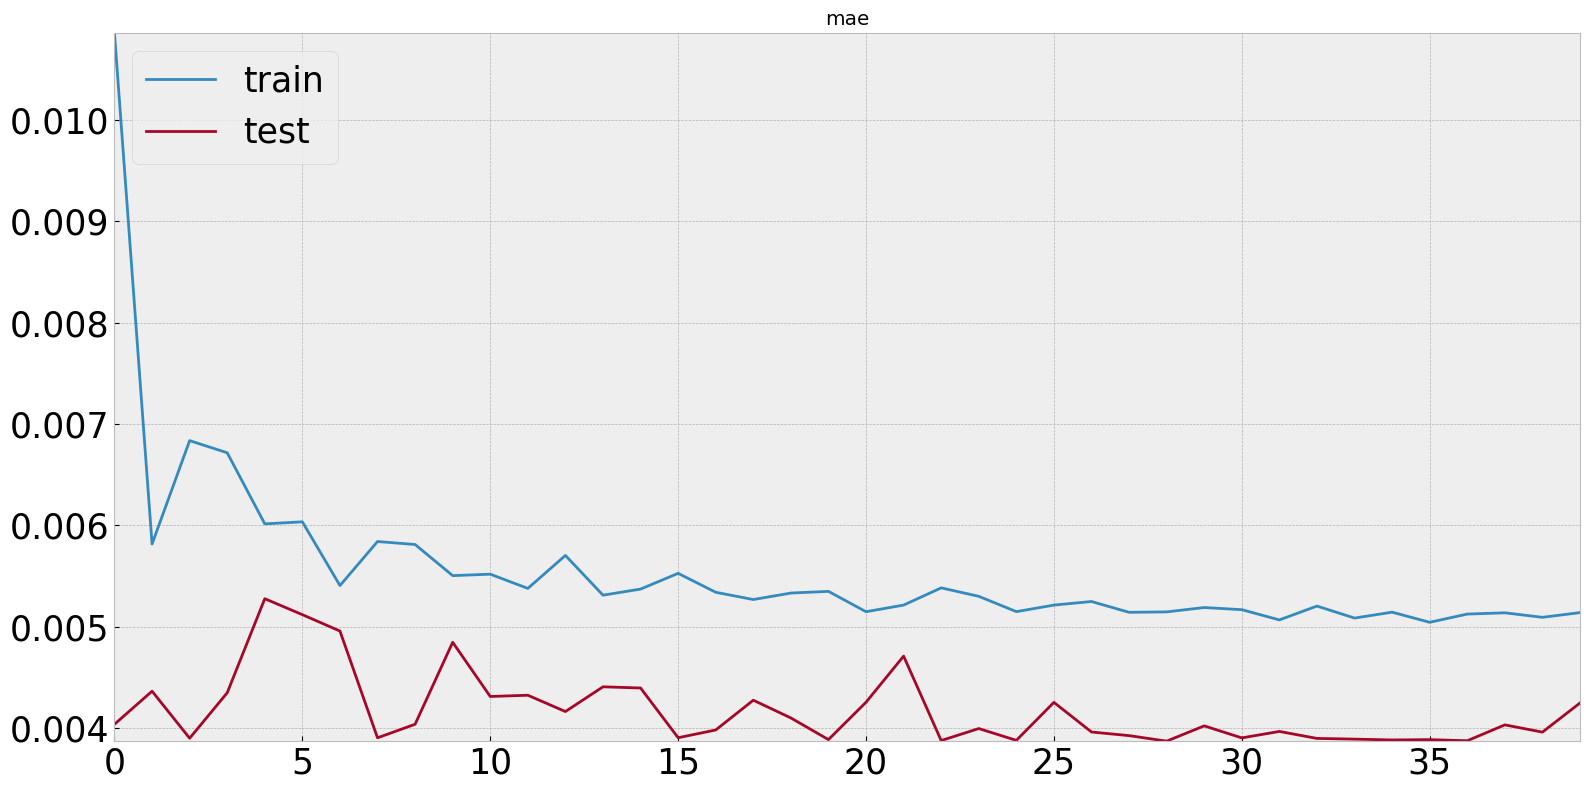

44/44 [==============================] - 1s 12ms/step


In [14]:
def build_lstm(input_shape):
    input = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(input)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation="linear")(x)
    return Model(input, x)

model = build_lstm((WINDOWS*TIMESTEPS, FEATURES))
model.compile(loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=40, validation_data=(x_test, y_test))
plot_training(history, 'mae')

evals['LSTM'] = eval('LSTM', model.predict(x_test), y_test)

In [15]:
evals

,Persistance,Zero,Mean,LR,LSTM
RMSE,0.007791,0.005563,0.005567,0.005762,0.005832
MAE,0.005549,0.003886,0.003896,0.004054,0.004246


Currently, Zero & Mean are clear winners with the other models really struggling to learn relevant features. Let us try generating CPC embeddings to improve LR. 

# Data Generation for CPC

Example

Batches: 10
x shape: (512, 10, 25, 1), y shape: (512, 25, 1), labels shape: (512,)


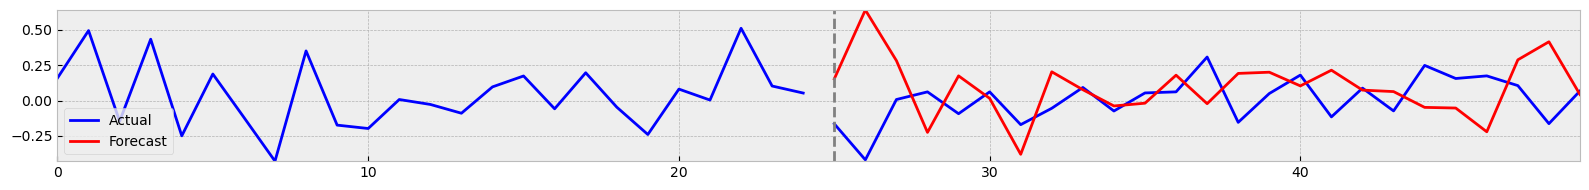

In [16]:
# Test generator
dg = DataGenerator(x_train, batch_size=BATCH_SIZE, shuffle=True, timesteps=TIMESTEPS, n_windows=WINDOWS)
print('Batches:', len(dg))

# Get the first batch
(bx, by), labels = dg.__getitem__(0)
print(f"x shape: {bx.shape}, y shape: {by.shape}, labels shape: {labels.shape}")

plot_forecast(bx[0, -1, :, 0], by[0, :, 0], by[1, :, 0])

# CPC Model Architecture

In [17]:
def build_encoder(input_shape, code_size):
    input = Input(shape=input_shape)
    x = Conv1D(16, 7, activation='relu', padding='same')(input)
    x = Conv1D(32, 5, activation='relu', padding='same')(x)
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    return Model(input, x, name='encoder')

encoder = build_encoder((TIMESTEPS, FEATURES), CODE_SIZE)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 25, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 25, 16)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            2592      
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 64)            6208      
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 encoder_embedding (Dense)   (None, 32)                51232     
                                                                 
Total params: 60,160
Trainable params: 60,160
Non-trainable

In [18]:
def build_context(input_shape, code_size):
    '''Build the autoregressive model doing predictions'''
    input = Input(shape=input_shape)
    x = GRU(16, return_sequences=False, name="context")(input)
    x = Dense(code_size, activation="linear", name="preds")(x)
    return Model(input, x, name="context")

context = build_context((WINDOWS, CODE_SIZE), CODE_SIZE)
context.summary()

Model: "context"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 32)]          0         
                                                                 
 context (GRU)               (None, 16)                2400      
                                                                 
 preds (Dense)               (None, 32)                544       
                                                                 
Total params: 2,944
Trainable params: 2,944
Non-trainable params: 0
_________________________________________________________________


In [19]:
x_input = Input((WINDOWS, TIMESTEPS, FEATURES))
# Used to distribute the encoder across the windows
x_encoded = TimeDistributed(encoder)(x_input)

y_pred = context(x_encoded)

y_input = Input((TIMESTEPS, FEATURES))
y_encoded = encoder(y_input)

# Binary crossentropy between the predictions and the actual values
output = K.mean(y_encoded * y_pred, axis=-1)
output = K.sigmoid(output)

model = Model(inputs=[x_input, y_input], outputs=output, name='CPC')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
model.summary()

Model: "CPC"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 10, 25, 1)]  0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 25, 1)]      0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 10, 32)      60160       ['input_4[0][0]']                
 ted)                                                                                             
                                                                                                  
 encoder (Functional)           (None, 32)           60160       ['input_5[0][0]']              

In [20]:
train_gen = DataGenerator(x_train, batch_size=BATCH_SIZE, shuffle=True, timesteps=TIMESTEPS, n_windows=WINDOWS)
test_gen = DataGenerator(x_test, batch_size=BATCH_SIZE, shuffle=True, timesteps=TIMESTEPS, n_windows=WINDOWS)

In [21]:
history = model.fit(train_gen, epochs=40, validation_data=test_gen)

Epoch 1/40
10/10 [==============================] - 2s 77ms/step - loss: 0.6931 - binary_accuracy: 0.5098 - val_loss: 0.6931 - val_binary_accuracy: 0.4980
Epoch 2/40
10/10 [==============================] - 0s 36ms/step - loss: 0.6931 - binary_accuracy: 0.4994 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 3/40
10/10 [==============================] - 0s 36ms/step - loss: 0.6923 - binary_accuracy: 0.4982 - val_loss: 0.6920 - val_binary_accuracy: 0.4346
Epoch 4/40
10/10 [==============================] - 0s 36ms/step - loss: 0.6878 - binary_accuracy: 0.5016 - val_loss: 0.6924 - val_binary_accuracy: 0.4971
Epoch 5/40
10/10 [==============================] - 0s 35ms/step - loss: 0.6706 - binary_accuracy: 0.5660 - val_loss: 0.6656 - val_binary_accuracy: 0.5742
Epoch 6/40
10/10 [==============================] - 0s 35ms/step - loss: 0.6499 - binary_accuracy: 0.5992 - val_loss: 0.6552 - val_binary_accuracy: 0.5869
Epoch 7/40
10/10 [==============================] - 0s 46ms/step - los

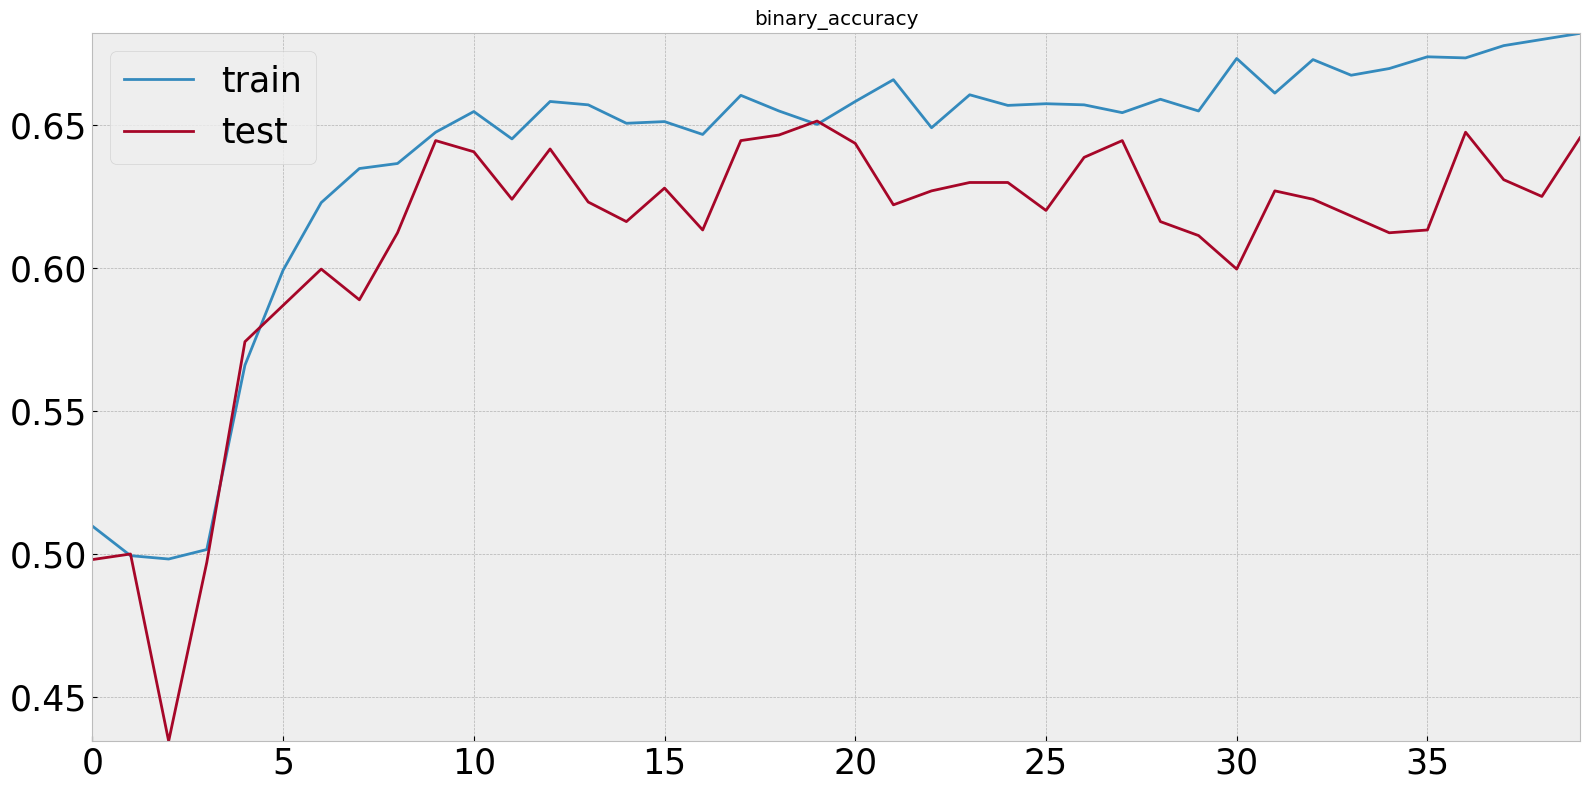

In [22]:
plot_training(history, 'binary_accuracy')

In [23]:
# Save the encoder
# encoder.save('encoder.h5')

# Analysis of Embeddings

If you want to load the best performing encoder from the study, uncomment the following code:

In [26]:
# encoder = load_model('encoders/encoderJPY_28_08_s1.3.h5', compile=True)
# print("Best encoder loaded")

In [25]:
# reloading without windowing (needed for LR)
x_train, x_test, y_train, y_test = load_data(timeseries,  TIMESTEPS, test_ratio=0.2)
x_train.shape

Outliers 0.021903799967386648


(5732, 25)

In [26]:
# Compute embeddings for each window
x_train_embeds = encoder.predict(x_train)
x_test_embeds = encoder.predict(x_test)

45/45 [==============================] - 0s 2ms/step


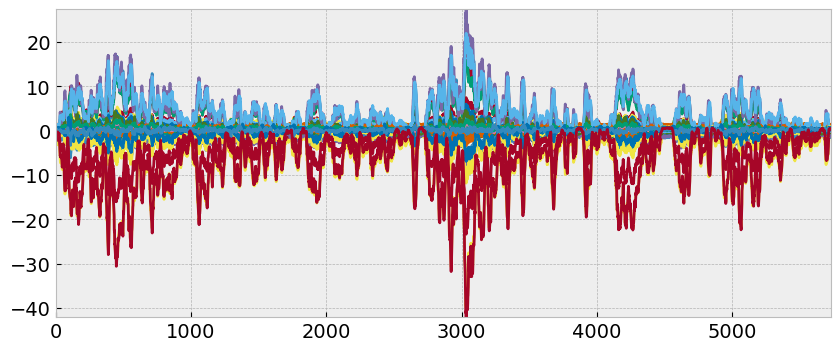

In [27]:
plot(x_train_embeds)

In [28]:
# Normalize each embedding vector to unit norm
x_train_embeds = x_train_embeds / np.linalg.norm(x_train_embeds, axis=1, keepdims=True)
x_test_embeds = x_test_embeds / np.linalg.norm(x_test_embeds, axis=1, keepdims=True)

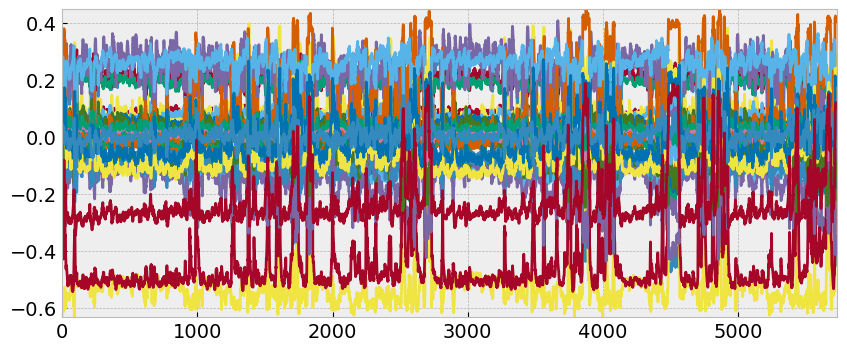

In [29]:
plot(x_train_embeds)

# Analysing Embeddings

Reduce to 2D.

In [30]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_tsne = tsne.fit_transform(x_train_embeds)

/Users/antonykrymski/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


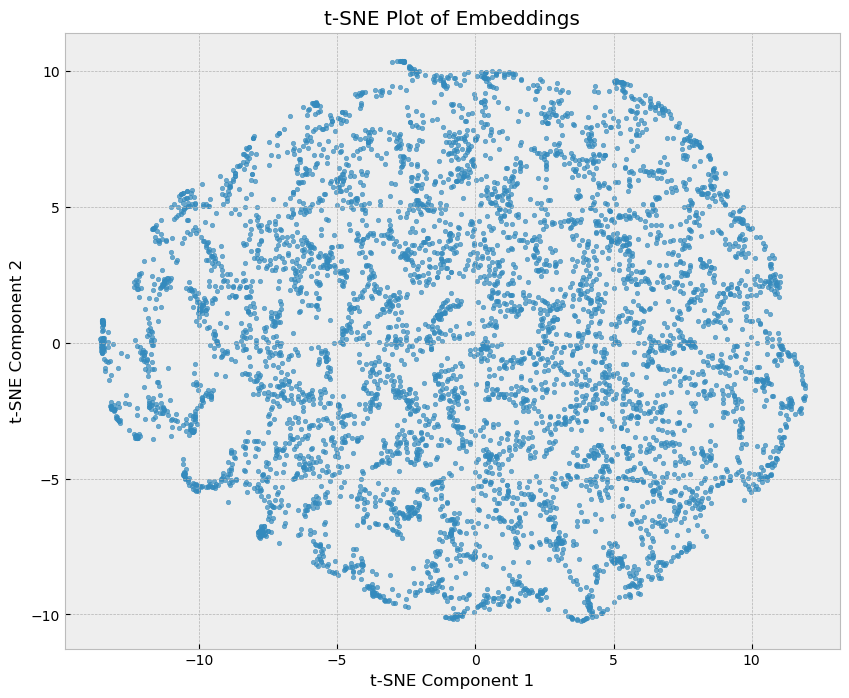

In [31]:
plt.figure(figsize=(10, 8))

plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], s=10, alpha=0.7)
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

Find ideal number of clusters.

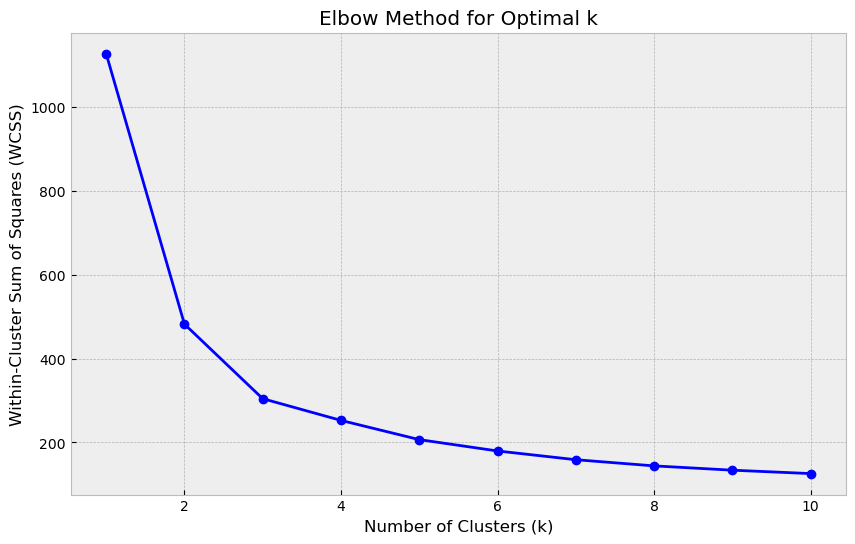

In [32]:
wcss = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(x_train_embeds)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

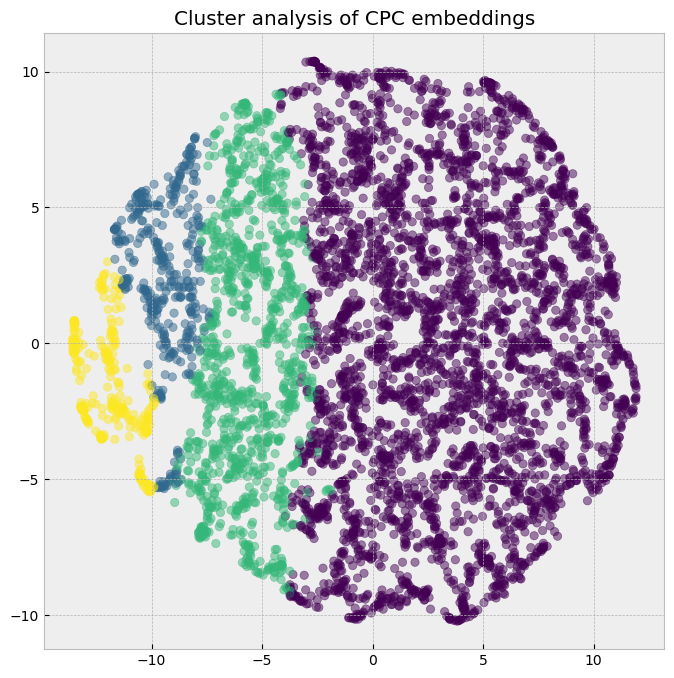

In [33]:
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(x_train_embeds)

plt.figure(figsize=(8, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('Cluster analysis of CPC embeddings')
plt.show()

# Downstream Task

Doing LR with embeddings.

In [34]:
# Linear Regression with CPC embeddings
reg_model = LinearRegression()
reg_model.fit(x_train_embeds, y_train)
evals['CPC-LR'] = eval('CPC-LR', reg_model.predict(x_test_embeds), y_test)
evals

,Persistance,Zero,Mean,LR,LSTM,CPC-LR
RMSE,0.007791,0.005563,0.005567,0.005762,0.005832,0.005490
MAE,0.005549,0.003886,0.003896,0.004054,0.004246,0.003855


Embeddings significant improve LR results. Performs better than all benchmarks.

# Optimising for Sharpe

## USDJPY

In [35]:
train_returns = timeseries[TIMESTEPS-1:][:len(x_train)]
test_returns = timeseries[-len(x_test)-1:-1]

Strategy Sharpe 1.3025034949295422
Benchmark Sharpe 0.5305891000168451


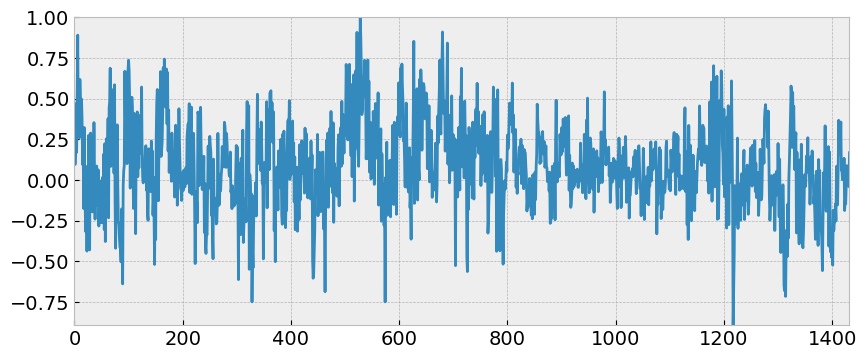

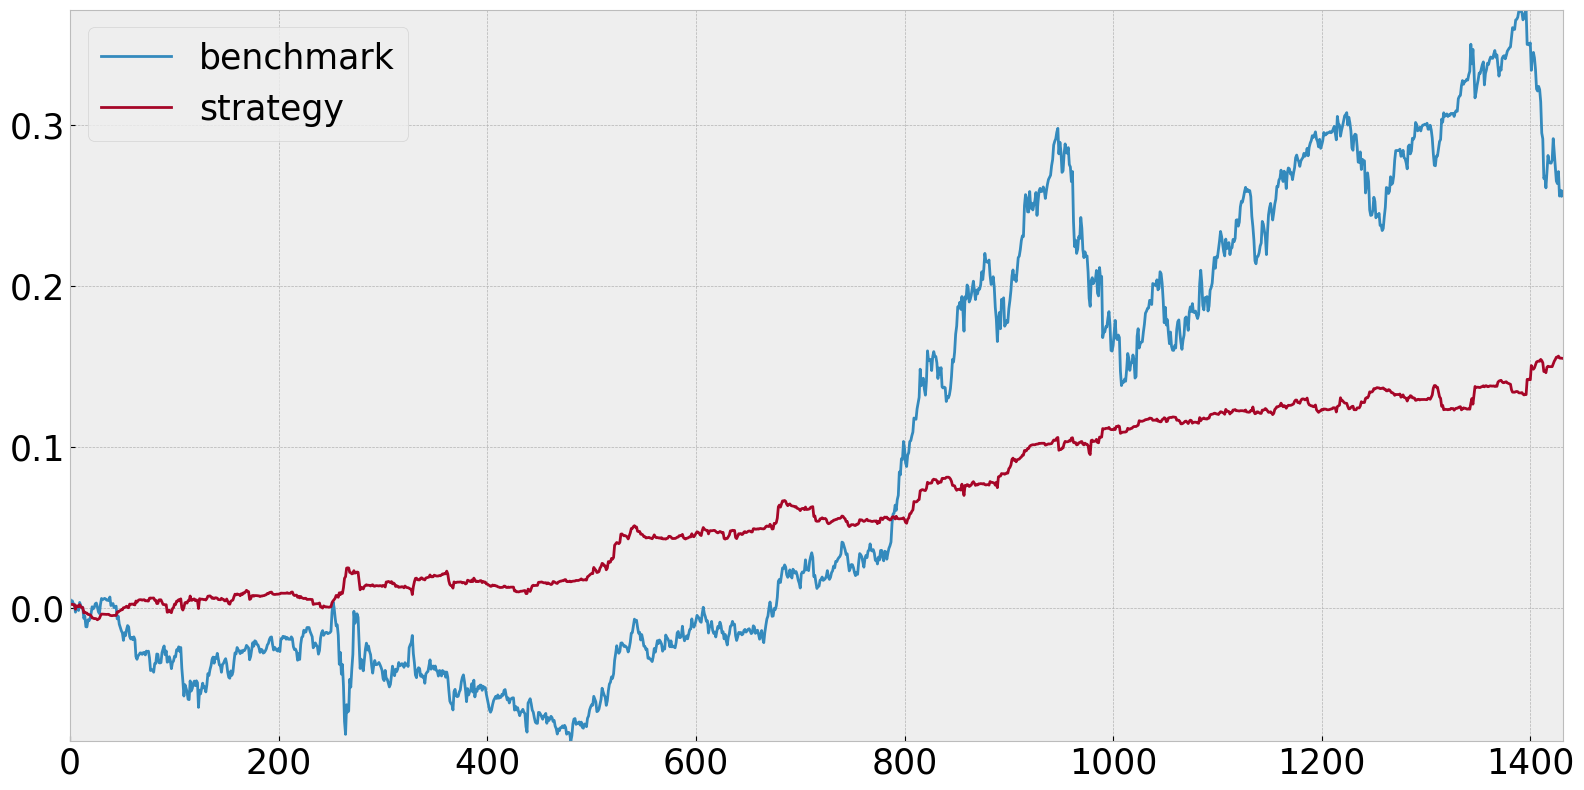

In [36]:
allocations = reg_model.predict(x_test_embeds)

m = 1 / max(allocations)
allocations = (allocations * m)
portfolio_returns = test_returns[1:] * allocations[:-1]

print('Strategy Sharpe', sharpe_ratio(portfolio_returns).numpy())
print('Benchmark Sharpe', sharpe_ratio(test_returns).numpy())

plot(allocations)
plot_timeseries(index=np.arange(len(test_returns)-1), benchmark=np.cumsum(test_returns[1:]), strategy=np.cumsum(portfolio_returns))

## USDSGD

In [38]:
timeseries = download('USDSGD=X')['Close']
# Transform to log returns
timeseries = np.log(timeseries).diff().dropna()

def load_data(w=None):
    X = timeseries.values

    # remove outliers
    outliers = np.quantile(np.abs(X), 0.99)
    X = np.clip(X, -outliers, outliers)
    print('Outliers', outliers)

    # scale
    X = X / outliers

    # generate lags
    X = window(X, w).astype(np.float32)
    y = timeseries[w:]
    return split(X, y, 0.2)

x_train, x_test, y_train, y_test = load_data(WINDOWS * TIMESTEPS)

assert(np.isfinite(x_train).all() == True)
assert(np.isfinite(y_train).all() == True)

encoder = load_model('encoders/encoderJPY_28_08_s1.3.h5', compile=True)

x_train, x_test, y_train, y_test = load_data(TIMESTEPS)
# Compute embeddings for each window
x_train_embeds = encoder.predict(x_train)
x_test_embeds = encoder.predict(x_test)
# Normalize each embedding vector to unit norm
x_train_embeds = x_train_embeds / np.linalg.norm(x_train_embeds, axis=1, keepdims=True)
x_test_embeds = x_test_embeds / np.linalg.norm(x_test_embeds, axis=1, keepdims=True)
# Linear Regression with CPC embeddings
reg_model = LinearRegression()
reg_model.fit(x_train_embeds, y_train)
evals['CPC-LR-SGD'] = eval('CPC-LR', reg_model.predict(x_test_embeds), y_test)
evals

Outliers 0.010593058981339208
Outliers 0.010593058981339208
34/34 [==============================] - 0s 3ms/step


[0.0027204909976968807, 0.0020833066760753945]

In [39]:
train_returns = timeseries[TIMESTEPS-1:][:len(x_train)]
test_returns = timeseries[-len(x_test)-1:-1]

Strategy Sharpe 0.9752098308382069
Benchmark Sharpe -0.3420135365934825


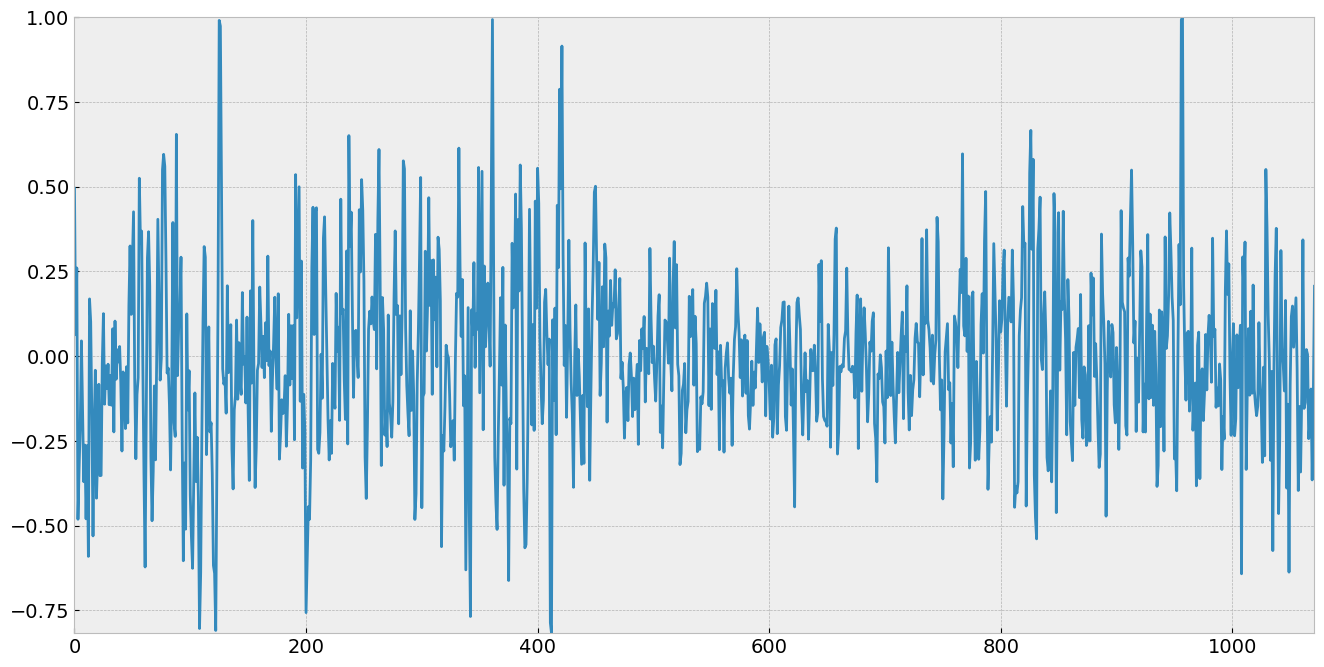

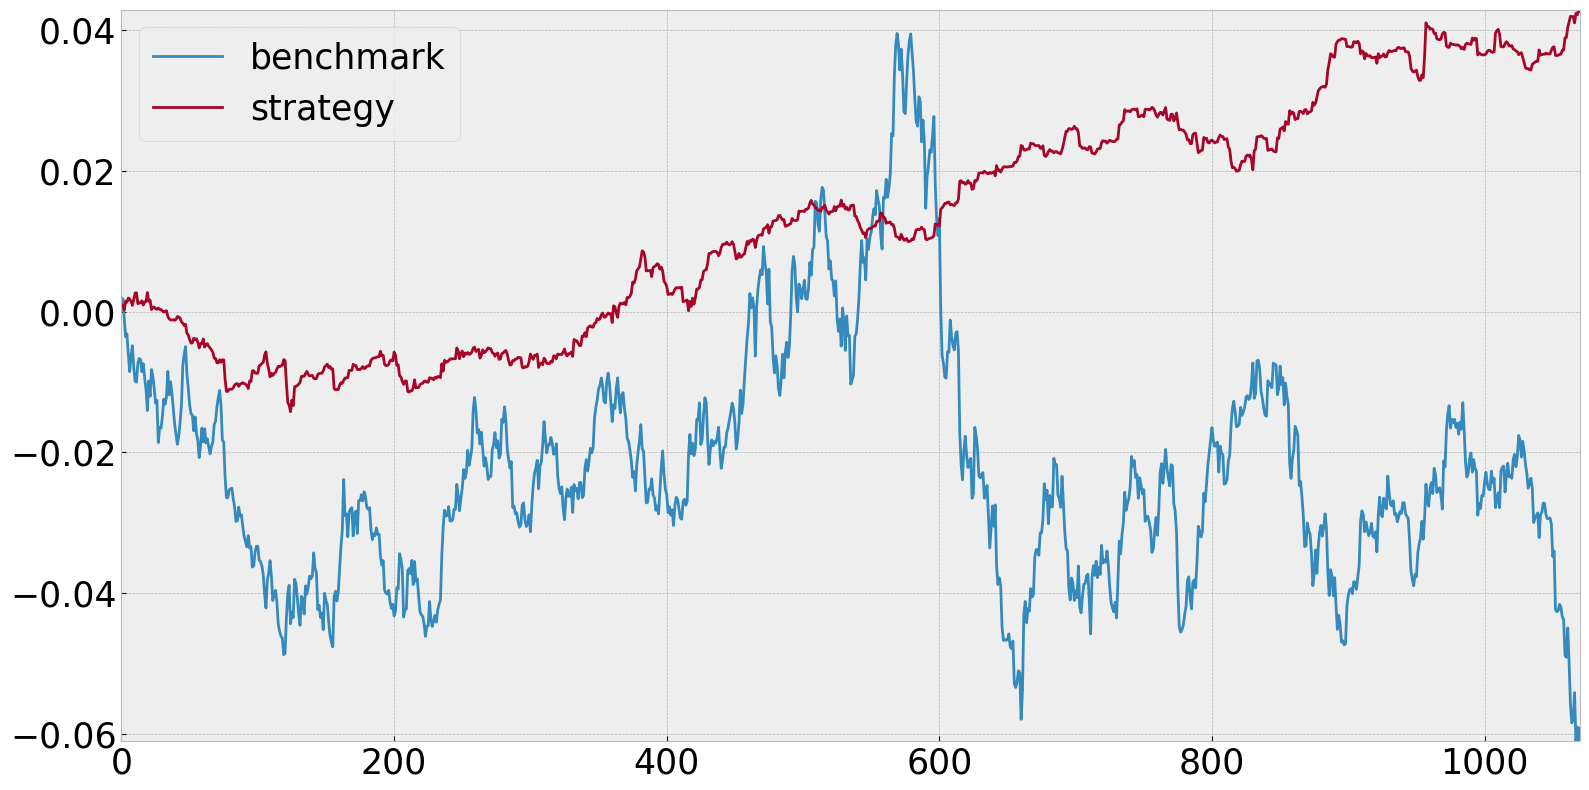

In [40]:
allocations = reg_model.predict(x_test_embeds)
m = 1 / max(abs(allocations))
allocations = (allocations * m)
portfolio_returns = test_returns[1:] * allocations[:-1]

print('Strategy Sharpe', sharpe_ratio(portfolio_returns).numpy())
print('Benchmark Sharpe', sharpe_ratio(test_returns).numpy())

plot(allocations, True)
plot_timeseries(index=np.arange(len(test_returns)-1), benchmark=np.cumsum(test_returns[1:]), strategy=np.cumsum(portfolio_returns))

## EURGBP

In [41]:
timeseries = download('EURGBP=X')['Close']
# Transform to log returns
timeseries = np.log(timeseries).diff().dropna()

def load_data(w=None):
    X = timeseries.values

    # remove outliers
    outliers = np.quantile(np.abs(X), 0.99)
    X = np.clip(X, -outliers, outliers)
    print('Outliers', outliers)

    # scale
    X = X / outliers

    # generate lags
    X = window(X, w).astype(np.float32)
    y = timeseries[w:]
    return split(X, y, 0.2)

x_train, x_test, y_train, y_test = load_data(WINDOWS * TIMESTEPS)

assert(np.isfinite(x_train).all() == True)
assert(np.isfinite(y_train).all() == True)

encoder = load_model('encoders/encoderJPY_28_08_s1.3.h5', compile=True)

x_train, x_test, y_train, y_test = load_data(TIMESTEPS)
# Compute embeddings for each window
x_train_embeds = encoder.predict(x_train)
x_test_embeds = encoder.predict(x_test)
# Normalize each embedding vector to unit norm
x_train_embeds = x_train_embeds / np.linalg.norm(x_train_embeds, axis=1, keepdims=True)
x_test_embeds = x_test_embeds / np.linalg.norm(x_test_embeds, axis=1, keepdims=True)
# Linear Regression with CPC embeddings
reg_model = LinearRegression()
reg_model.fit(x_train_embeds, y_train)
evals['CPC-LR-GBP'] = eval('CPC-LR', reg_model.predict(x_test_embeds), y_test)
evals

Outliers 0.015852559214601283
Outliers 0.015852559214601283
42/42 [==============================] - 0s 2ms/step


[0.006035416797259843, 0.003168230398924477]

In [42]:
train_returns = timeseries[TIMESTEPS-1:][:len(x_train)]
test_returns = timeseries[-len(x_test)-1:-1]

Strategy Sharpe 0.7402635904359209
Benchmark Sharpe -0.12145803209995194


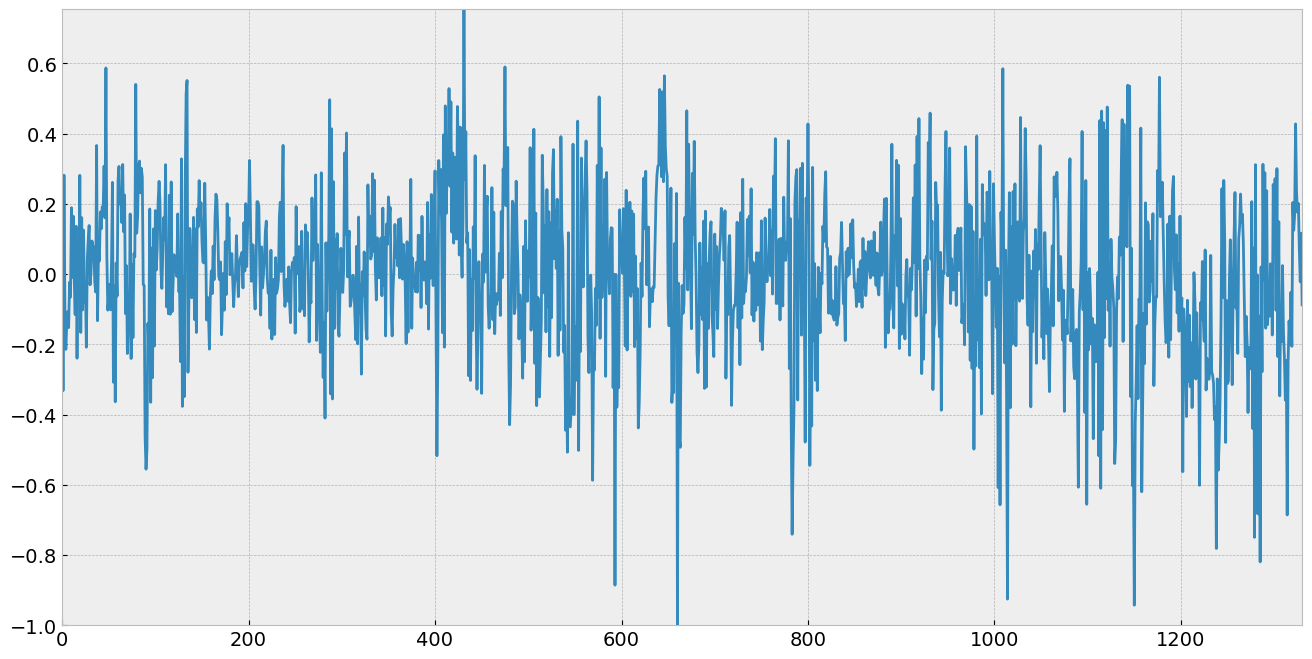

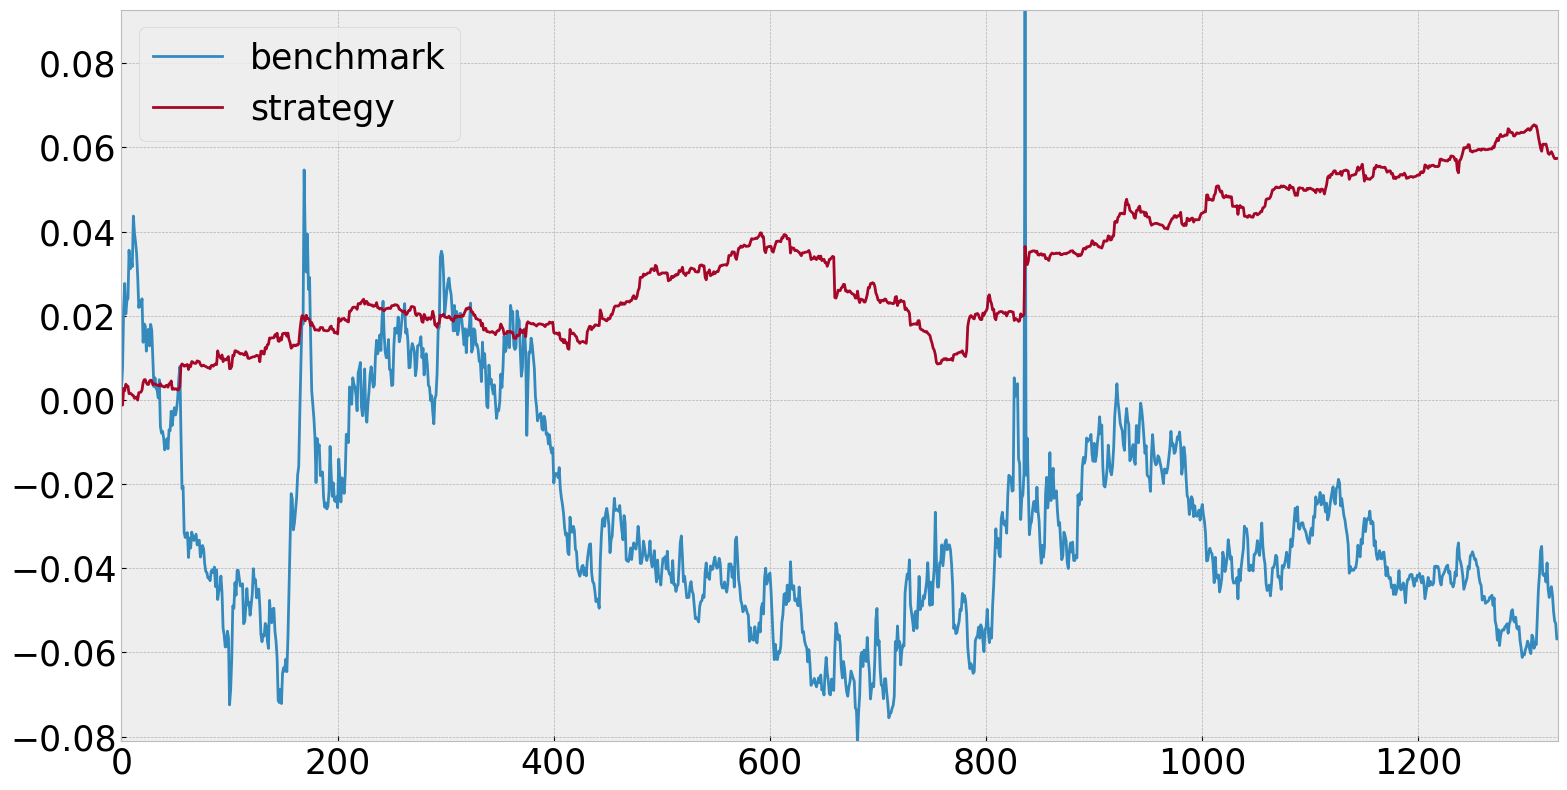

In [43]:
allocations = reg_model.predict(x_test_embeds)
m = 1 / max(abs(allocations))
allocations = (allocations * m)
portfolio_returns = test_returns[1:] * allocations[:-1]

print('Strategy Sharpe', sharpe_ratio(portfolio_returns).numpy())
print('Benchmark Sharpe', sharpe_ratio(test_returns).numpy())

plot(allocations, True)
plot_timeseries(index=np.arange(len(test_returns)-1), benchmark=np.cumsum(test_returns[1:]), strategy=np.cumsum(portfolio_returns))